
# KUL-CGK

## Data Preparation

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from tabulate import tabulate

In [ ]:
df_kul_cgk = pd.read_excel('/content/kul_cgk.xlsx', sheet_name=0, parse_dates=['Tanggal'])

In [ ]:
df_kul_cgk.head()

,Tanggal,Harga
0,2022-09-07,1116970.0
1,2022-09-08,1116855.0
2,2022-09-09,1117184.0
3,2022-09-10,1117088.0
4,2022-09-11,1111940.0


In [ ]:
df_kul_cgk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  70 non-null     datetime64[ns]
 1   Harga    70 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 KB


In [ ]:
df_kul_cgk.set_index('Tanggal', inplace=True)
df_kul_cgk.tail(100)

,Harga
Tanggal,
2022-09-07,1116970.0
2022-09-08,1116855.0
2022-09-09,1117184.0
2022-09-10,1117088.0
2022-09-11,1111940.0
...,...
2022-11-11,1901946.0
2022-11-12,1924049.0
2022-11-13,1922750.0


## EDA

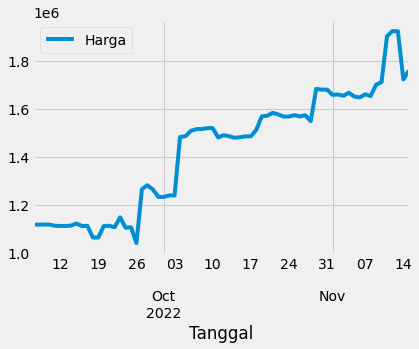

In [ ]:
df_kul_cgk.plot(kind='line')
plt.show()

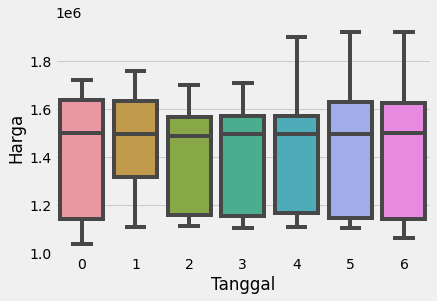

In [ ]:
sns.boxplot(x=df_kul_cgk.index.dayofweek, y=df_kul_cgk['Harga'])
plt.show()

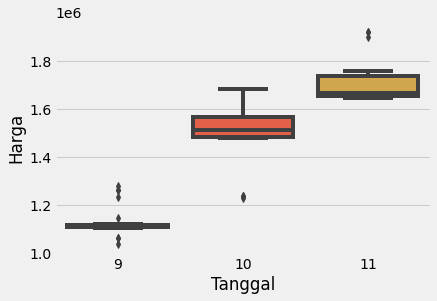

In [ ]:
sns.boxplot(x=df_kul_cgk.index.month, y=df_kul_cgk['Harga'])
plt.show()

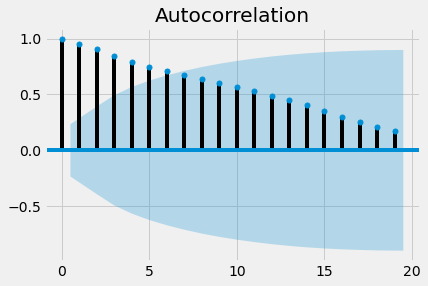

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

plot_acf(df_kul_cgk['Harga'])
plt.show()

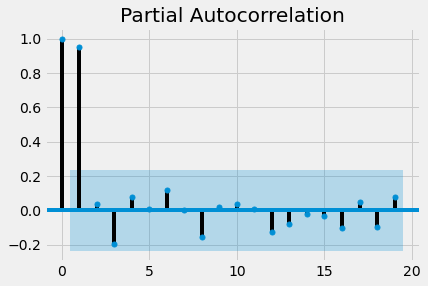

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_kul_cgk['Harga'], method='ywm')
plt.show()

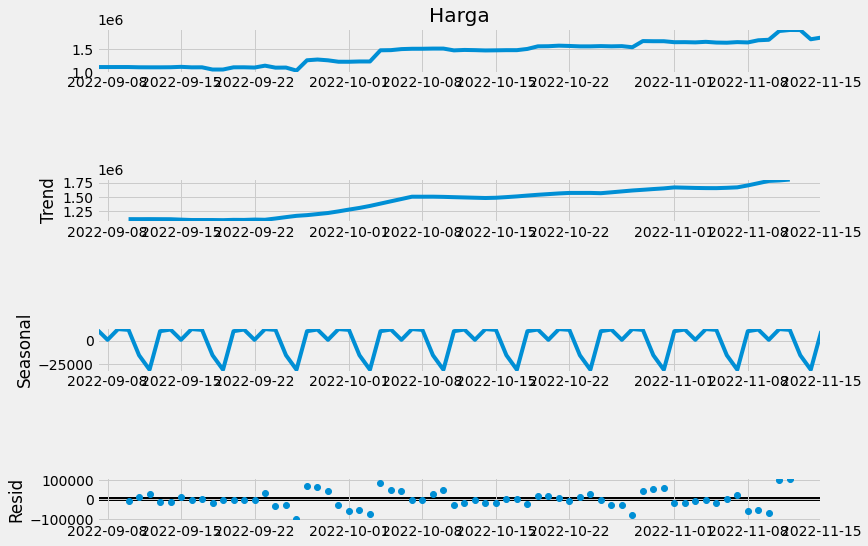

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_kul_cgk['Harga'])
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

ide: ambil semua lag yg autocorr nya diluar biru, buatnya bukan lag2=lag2 aja, tapi lag2= lag1,lag2 dst untuk lag lainnya. Ini lebih make sense daripada ambil satu lag aja tiap nyoba.
link buat belajar parameter:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?
atau ga cari yg lain gpp, mgt guys maap aku ngaret terus <3

## Tuning Train-Test dan Lag

In [ ]:
#build lags
def create_features(df,n_lag,label=None):
    """
    Creates time series features from datetime index
    """
    df['lag'] = df['Harga'].shift(n_lag)
    
    X = df[['lag']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
from datetime import timedelta, datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
df_kul_cgk.tail(30)

,Harga
Tanggal,
2022-10-17,1484863.0
2022-10-18,1511696.0
2022-10-19,1568170.0
2022-10-20,1570789.0
2022-10-21,1582716.0
2022-10-22,1576368.0
2022-10-23,1567490.0
2022-10-24,1567490.0
2022-10-25,1573384.0


In [ ]:
#tuning train test split
def cross_validation(data,n_lags,n_splits=10,n_iter=10):
  s= datetime(2022,9,7)  #hari pertama data diambil
  t = datetime(2022,10,17)  #100 hari terakhir
  days_until_depart=30
  rmse_split_mean=[]
  rmse_total_split=[]
  print('=== CROSS VALIDATE LAGS {} START ==='.format(n_lags))
  for i in range(0,days_until_depart,n_splits):
    split_date = t
    s_train = data.loc[s+timedelta(days=n_lags)<data.index].copy()
    train = s_train.loc[s_train.index <= split_date].copy()
    test = data.loc[data.index >= split_date].copy()
    X_train, y_train = create_features(train,n_lags,label='Harga')
    X_test, y_test = create_features(test,n_lags,label='Harga')
    split=30
    tscv = TimeSeriesSplit(n_splits=split)
    rmse=[]
    param=[]
    for j in range(n_iter):
      reg = xgb.XGBRegressor()
      reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=0)
      y_pred=reg.predict(X_test)
      rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse_total_split.append(rmse)
    rmse_split_mean.append(np.mean(rmse))
    t = t - timedelta(days=10)
  rmse_total_split = np.array( rmse_total_split)
  print('Lags {0} RMSE: {1}\n'.format(n_lags, rmse_split_mean))
  return rmse_total_split, rmse_split_mean

In [ ]:
rmse_lags3, rmse_lags3_mean = cross_validation(df_kul_cgk, n_lags=3)
rmse_lags2, rmse_lags2_mean = cross_validation(df_kul_cgk, n_lags=2)
rmse_lags1, rmse_lags1_mean = cross_validation(df_kul_cgk, n_lags=1)

=== CROSS VALIDATE LAGS 3 START ===
[11:31:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:lin

In [ ]:
print('Lags 3 RMSE Mean:', np.mean(rmse_lags3_mean))
print('Lags 2 RMSE Mean:', np.mean(rmse_lags2_mean))
print('Lags 1 RMSE Mean:', np.mean(rmse_lags1_mean))

Lags 3 RMSE Mean: 325152.42115152354
Lags 2 RMSE Mean: 294336.6981203304
Lags 1 RMSE Mean: 284061.63007141935


In [ ]:
rmse_lags1.mean(axis=1)

array([199820.59049126, 171301.95069342, 481062.34902958])

## Tuning Parameter

Ambil lag= 1 dan test=50, karena mean RMSE nya paling rendah

In [ ]:
df_kul_cgk.tail(20)

,Harga
Tanggal,
2022-10-27,1572669.0
2022-10-28,1548301.0
2022-10-29,1682846.0
2022-10-30,1679596.0
2022-10-31,1679596.0
2022-11-01,1658022.0
2022-11-02,1659368.0
2022-11-03,1654305.0
2022-11-04,1666324.0


In [ ]:
s= datetime(2022,9,7)
t=datetime(2022,10,27)
split_date = t
s_train = df_kul_cgk.loc[s+timedelta(days=1)<df_kul_cgk.index].copy()
train = s_train.loc[s_train.index <= split_date].copy()
test = df_kul_cgk.loc[df_kul_cgk.index >= split_date].copy()
X_train, y_train = create_features(train,1,label='Harga')
X_test, y_test = create_features(test,1,label='Harga')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=20)
rmse=[]
param_tun=[]
for i in range(10):
  params = {'max_depth': [3, 5, 6, 7, 8, 9, 10],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'min_child_weight':[6, 5, 4, 3, 2],
           'subsample': np.arange(0.5, 0.75, 1.0),            #Typical values: 0.5-1
           'colsample_bytree': np.arange(0.5, 0.75, 1.0),     #Typical values: 0.5-1
           'colsample_bylevel': np.arange(0.5, 0.75, 1.0),    #Typical values: 0.5-1
           'eta':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],           #Typical final values to be used: 0.01-0.2  
           'lambda':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L2 regularization, (0,0.1)
           'gamma':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],        #Typical final values to be used: 0.01-0.2 
           'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L1 regularization, (0,0.1)
           'n_estimators': [100, 500, 1000]}
  xgbr = xgb.XGBRegressor(seed = 20)
  clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=100,cv=tscv,
                         verbose=1)
  clf.fit(X_train,y_train)
  rmse.append((-clf.best_score_)**(1/2.0))
  param_tun.append(clf.best_params_)

Streaming output truncated to the last 5000 lines.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:51:29] WARNING: /workspace/src/objective/regression_obj.

In [ ]:
print('Nilai RMSE Maksimal=',np.max(rmse))
print('Nilai RMSE Minimal=',np.min(rmse))
print('Nilai Rata-rata RMSE=',np.mean(rmse))
print('Nilai Median RMSE=',np.median(rmse))
print('Parameter untuk RMSE Minimal:',param_tun[rmse.index(np.min(rmse))])

Nilai RMSE Maksimal= 78062.66503306964
Nilai RMSE Minimal= 77788.59317819656
Nilai Rata-rata RMSE= 77870.23694565576
Nilai Median RMSE= 77805.51725811501
Parameter untuk RMSE Minimal: {'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'lambda': 0.01, 'gamma': 0.015, 'eta': 0.15, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 1e-05}


## Prediction

{'subsample': 0.5, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.1, 'lambda': 0.01, 'gamma': 0.015, 'eta': 0.15, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 1e-05}

In [ ]:
reg = xgb.XGBRegressor(subsample= 0.5, min_child_weight=2,n_estimators=1000,max_depth=7, gamma=0.015,
                       learning_rate=0.1,eta=0.15,reg_alpha=1e-05,reg_lambda=0.001, colsample_bylevel= 0.5,colsample_bytree= 0.5)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[08:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, eta=0.15, gamma=0.015,
             max_depth=7, min_child_weight=2, n_estimators=1000,
             reg_alpha=1e-05, reg_lambda=0.001, subsample=0.5)

In [ ]:
test['Test_Prediksi'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)

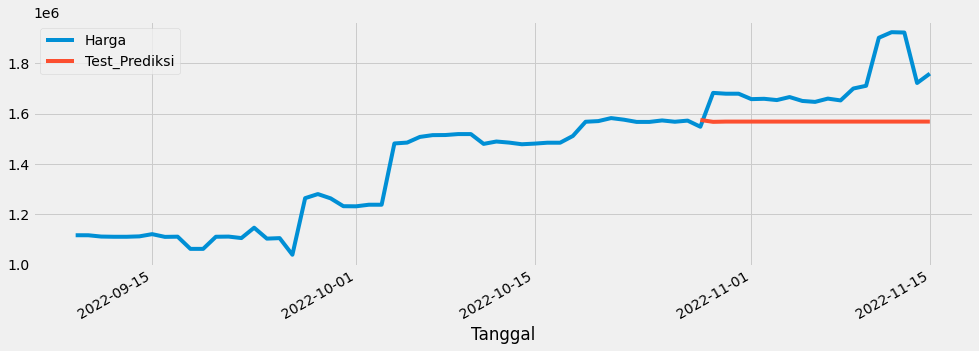

In [ ]:
_ = all[['Harga','Test_Prediksi']].plot(figsize=(15, 5))

In [ ]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [ ]:
X_test

,lag
Tanggal,
2022-10-27,NaN
2022-10-28,1572669.0
2022-10-29,1548301.0
2022-10-30,1682846.0
2022-10-31,1679596.0
2022-11-01,1679596.0
2022-11-02,1658022.0
2022-11-03,1659368.0
2022-11-04,1654305.0


In [ ]:
df_kul_cgk2 = df_kul_cgk.copy()
df_kul_cgk2['Prediksi'] = 0

df_kul_cgk2.tail(100)

,Harga,Prediksi
Tanggal,,
2022-09-07,1116970.0,0
2022-09-08,1116855.0,0
2022-09-09,1117184.0,0
2022-09-10,1117088.0,0
2022-09-11,1111940.0,0
...,...,...
2022-11-11,1901946.0,0
2022-11-12,1924049.0,0
2022-11-13,1922750.0,0


In [ ]:
y_test_pred.shape

(20,)

In [ ]:
df_kul_cgk2.iloc[:1, 1] = np.nan
df_kul_cgk2.iloc[1:-20, 1] = y_train_pred
df_kul_cgk2

,Harga,Prediksi
Tanggal,,
2022-09-07,1116970.0,NaN
2022-09-08,1116855.0,1145844.125
2022-09-09,1117184.0,1112592.125
2022-09-10,1117088.0,1112862.375
2022-09-11,1111940.0,1103572.000
...,...,...
2022-11-11,1901946.0,0.000
2022-11-12,1924049.0,0.000
2022-11-13,1922750.0,0.000


In [ ]:
df_kul_cgk2.iloc[-20:, 1] = y_test_pred
df_kul_cgk2

,Harga,Prediksi
Tanggal,,
2022-09-07,1116970.0,NaN
2022-09-08,1116855.0,1145844.125
2022-09-09,1117184.0,1112592.125
2022-09-10,1117088.0,1112862.375
2022-09-11,1111940.0,1103572.000
...,...,...
2022-11-11,1901946.0,1568808.250
2022-11-12,1924049.0,1568808.250
2022-11-13,1922750.0,1568808.250


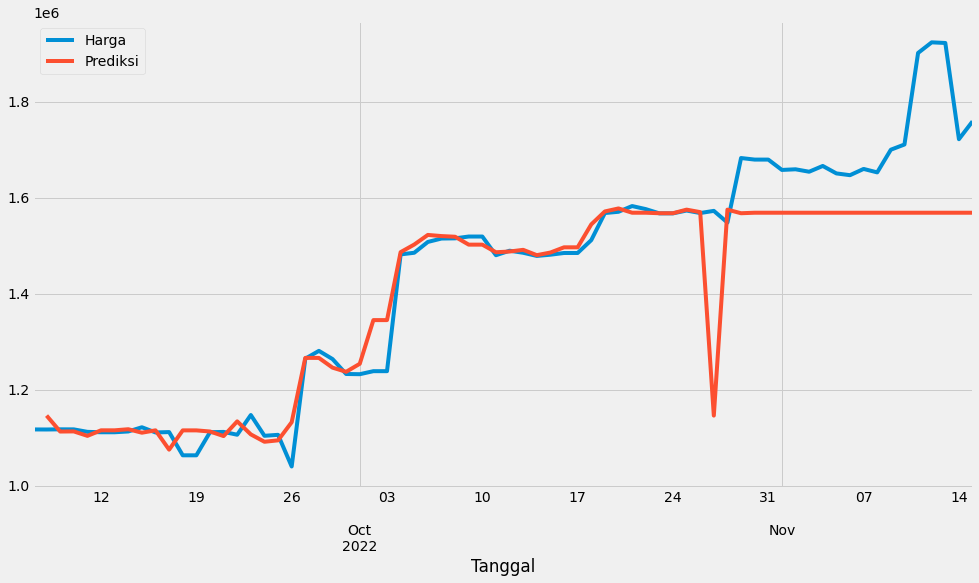

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
df_kul_cgk2.plot(kind='line', ax=ax)
plt.show()

## Forecast

In [ ]:
from datetime import timedelta, datetime
def forecast(data, nlags, days_until_depart):
  t = datetime(2022, 11, 15)
  time_list = [t]
  hasil_forecast=[1759311] #pokonya ini ambil data X_test indeksnya [-n_lags:], bebas lo ambilnya gimanss
  days_until_depart=47     #hari sblom brangkat, kalo lstm 1 hari sebelum berangkat

  for i in range(days_until_depart):
    forecast_={'lag':hasil_forecast}
    apaiya_df = pd.DataFrame(forecast_, index=time_list)
    fr=reg.predict(apaiya_df)
    list(fr)
    hasil_forecast.append(fr[i])
    time = t + timedelta(days=1)
    t = time
    time_list.append(time)
  return apaiya_df

In [ ]:
apaiya_df=forecast(X_test, 1, 47)

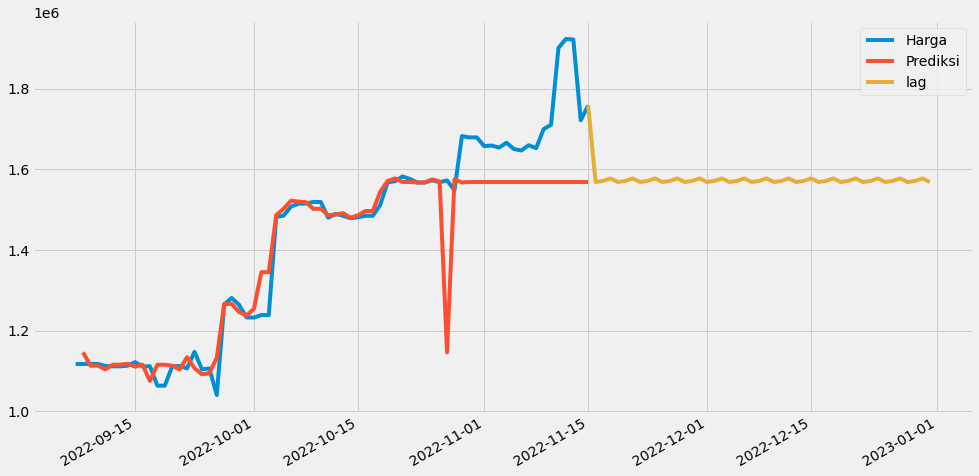

In [ ]:
#Membuat plot 

from datetime import timedelta, datetime
df_kul_cgk3 = df_kul_cgk2.append(apaiya_df)
fig, ax = plt.subplots(figsize=(15,8))
df_kul_cgk3.plot(kind='line', ax=ax)
plt.show()

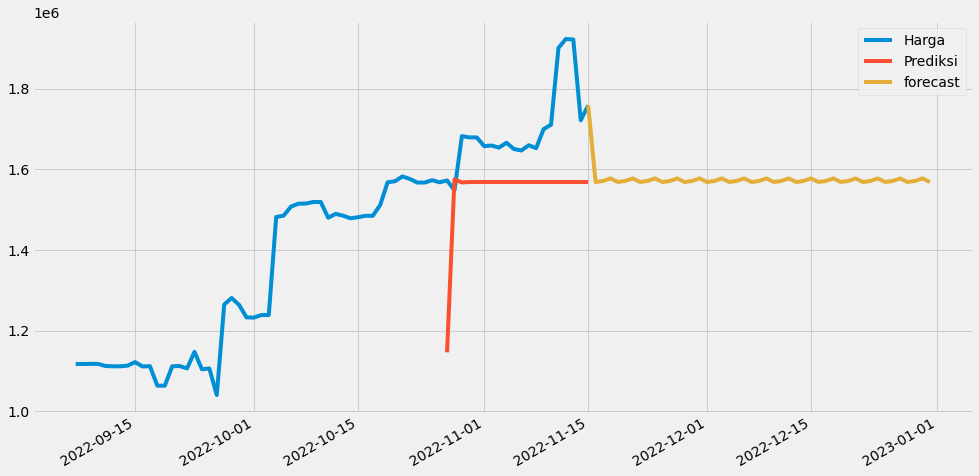

In [ ]:
#Membuat plot 

from datetime import timedelta, datetime
df_kul_cgk4 = df_kul_cgk3
df_kul_cgk4. rename(columns = {'lag':'forecast'}, inplace = True)
df_kul_cgk4.iloc[1:-67, 1] = np.nan
fig, ax = plt.subplots(figsize=(15,8))
df_kul_cgk4.plot(kind='line', ax=ax)
plt.show()

# Koefisien Variansi

In [ ]:
df_kul_cgk.describe()

,Harga
count,7.000000e+01
mean,1.427555e+06
std,2.485617e+05
min,1.039708e+06
25%,1.118269e+06
50%,1.487478e+06
75%,1.630994e+06
max,1.924049e+06


In [ ]:
print('Koefisien Variansi KUL-CGK:',(np.sqrt(mean_squared_error(y_test,y_test_pred))/1.427555e+06)*100,'%')

Koefisien Variansi KUL-CGK: 13.489681749397045 %


In [ ]:
np.sqrt(mean_squared_error(y_test,y_test_pred))

192572.626297605